In [2]:
# This file is modified from https://github.com/haotian-liu/LLaVA/

import argparse
import re
from io import BytesIO
import os, os.path as osp

import requests
import torch
from PIL import Image

from llava.constants import (DEFAULT_IM_END_TOKEN, DEFAULT_IM_START_TOKEN,
                             DEFAULT_IMAGE_TOKEN, IMAGE_PLACEHOLDER,
                             IMAGE_TOKEN_INDEX)
from llava.conversation import SeparatorStyle, conv_templates
from llava.mm_utils import (KeywordsStoppingCriteria, get_model_name_from_path,
                            process_images, tokenizer_image_token)
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init

def image_parser(args):
    out = args.image_file.split(args.sep)
    return out

def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        print("downloading image from url", args.video_file)
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


def load_images(image_files):
    out = []
    for image_file in image_files:
        image = load_image(image_file)
        out.append(image)
    return out


In [3]:
# sft example
model_name = "vila_3b_no_hamster"
model_path = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/checkpoints/finetuned/vila/"
base_name = None
base_path = None

# LoRA example -> set base_name (and path)
model_name = "vila_3b_sft_all_lora_amazon"
model_path = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/checkpoints/finetuned/vila/"
base_name = "Efficient-Large-Model/VILA1.5-3b"
base_path = None

############################################

model_name = "libero_processed_path_mask" # "libero_processed_path_mask", "libero_processed_path", "libero_processed_mask"
model_path = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/checkpoints/finetuned/vila/"
base_name = None # "Efficient-Large-Model/VILA1.5-3b"
base_path = None # model_path

model_name = "vila_3b_oxe_no_droid"
model_path = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/checkpoints/finetuned/vila/"
base_name = None # "Efficient-Large-Model/VILA1.5-3b"
base_path = None
prompt_type = "path" # "mask", "path_mask"

model_name = "vila_3b_oxe_no_droid_path_mask"
model_path = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/checkpoints/finetuned/vila/"
base_name = None # "Efficient-Large-Model/VILA1.5-3b"
base_path = None
prompt_type = "path_mask" # "mask", "path_mask"

# model_name = "vila_13b_bridge_droid_robopoint"
model_name = "vila_13b_bridge_robopoint"
model_path = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/checkpoints/finetuned/vila/"
base_name = None # "Efficient-Large-Model/VILA1.5-3b"
base_path = None
prompt_type = "path_mask" # "mask", "path_mask"

model_name = "vila_3b_all_path_mask"
model_path = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/checkpoints/finetuned/nvila/"
base_name = None # "Efficient-Large-Model/VILA1.5-3b"
base_path = None
prompt_type = "path_mask" # "mask", "path_mask"

args_dict = {
    
    # replace later
    "query": None,
    "image_file": None,

    # "video_file": None,
    "model_path": model_name if model_path is None else os.path.join(model_path, model_name),
    "conv_mode": "vicuna_v1", # "llava_v0", # "vicuna_v1",
    
    "model_base": base_name if base_path is None else os.path.join(base_path, base_name),
    "num_video_frames": 6,
    "sep": ",",
    "temperature": 0.2,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 1024,
}
args = argparse.Namespace(**args_dict)

In [4]:
# standard model
if args.model_base is None:
    disable_torch_init()
    model_name = get_model_name_from_path(args.model_path)
    tokenizer, model, image_processor, context_len = load_pretrained_model(args.model_path, model_name, args.model_base)
    print("standard", args.model_path, args.model_base)

# LoRA
else:
    disable_torch_init()
    
    from llava.model.builder import load_pretrained_model
    from peft import PeftModel
    tokenizer, base_model, image_processor, context_len = load_pretrained_model(
        args.model_base, get_model_name_from_path(args.model_base), model_base=None
    )

    model = PeftModel.from_pretrained(base_model, args.model_path)

    model = model.merge_and_unload()
    print("LoRA", args.model_path, args.model_base)


Loading checkpoint shards: 100%|██████████| 2/2 [00:54<00:00, 27.12s/it]


standard /lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/checkpoints/finetuned/nvila/vila_3b_all_path_mask None


In [133]:
# def get_query(quest):
#     return f"In the image, please execute the command described in <quest>{quest}</quest>.\nProvide a sequence of points denoting the trajectory of a robot gripper to achieve the goal.\nFormat your answer as a list of tuples enclosed by <ans> and </ans> tags. For example:\n<ans>[(25, 32), (32, 17), (13, 24), <action>Open Gripper</action>, (74, 21), <action>Close Gripper</action>, ...]</ans>\nThe tuple denotes point x and y location of the end effector of the gripper in the image. The action tags indicate the gripper action.\nThe coordinates should be integers ranging between 0 and 100, indicating the relative locations of the points in the image.\n"

# quest = "put both moka pots on the stove"
# # quest = "put the right moka pot on the stove"
# quest = "put both moka pots on the stove"
# image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/data/libero_10/train/images/train_libero_10_0.jpeg"

# quest = "put the grapes in the fruit bowl"
# # quest = "put the knife next to the spoon"
# # quest = "put the jelly on the cinnamon roll"
# # quest = "press down the french press"
# # quest = "pour the orange juice into the glass"
# # quest = "put the pineapple on the coffee cup"
# image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/convert_roboverse/breakfast.jpg"

# quest = "put the car in the box"
# # quest = "clean up the floor"
# quest = "put the tiger in the cardboard box"
# # quest = "clean up the toys"
# image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/convert_roboverse/toys.jpg"

# quest = "put the lemon in the green bowl"
# quest = "put the ketchup in the cyan bowl"
# image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/convert_roboverse/table.png"

# quest = "move both coffee makers to the right"
# image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/convert_roboverse/coffee_bar.png"

# quest = "pick up the pan"
# quest = "pick up the spoon"
# image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/example_imgs/droid_stove.png"


## pointing
# quest = "Locate any number of points situated on the pan. Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be integers between 0 and 100, indicating the normalized pixel locations of the points in the image."
# quest = "I want to have muesli for breakfast. Locate the item I need. Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be integers between 0 and 100, indicating the normalized pixel locations of the points in the image."
# quest = "Idenitfy points on the robot gripper. Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be integers between 0 and 100, indicating the normalized pixel locations of the points in the image."
# image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/convert_roboverse/droid_stove.png"

# quest = "Locate any number of points situated on drinks. Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be integers between 0 and 100, indicating the normalized pixel locations of the points in the image."
# quest = "Locate any number of points situated on cuttlery. Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be integers between 0 and 100, indicating the normalized pixel locations of the points in the image."
# image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/convert_roboverse/breakfast.jpg"

# args.query = query
## pointing


# args.query = get_query(quest)
# args.image_file = image_file

In [134]:
# MASK
quest = "Stack the magenta cube on top of the orange cube."
quest = "Stack the pink cube on top of the cyan cube."
args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/data/stack_platforms2_mask/test/images/test_stack_platforms2_mask_0_40.jpeg"

quest = "Pick up the pan."
args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/vila_utils/example_imgs/droid_stove.png"

# quest = "put both moka pots on the stove"
# args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/data/libero_10/train/images/train_libero_10_0.jpeg"

args.query = f"<image>\nIn the image, please mask according to the command described in <quest>{quest}</quest>.\nProvide a set of points denoting the areas the robot should mask to achieve the goal.\nFormat your answer as a list of tuples enclosed by <ans> and </ans> tags. For example:\n<ans>[(25, 32), (32, 17), (13, 24), (74, 21) ...]</ans>\nThe tuple denotes point x and y location of a mask in the image. \nThe coordinates should be integers ranging between 0 and 100, indicating the relative locations of the points in the image.\n"

In [135]:
from vila_utils.utils.prompts import get_prompt


# SWIPE

# quest = "swipe the mug to the left"
# quest = "pick up the mug"
# args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/data/amazon_real/images/train_amazon_real_6.jpg"
# args.query = get_prompt(quest, prompt_type)

# quest = "Stack the orange cube on top of the cyan cube."
# # quest = "swipe the orange cube to the right."
# quest = "Open the drawer and put the bowl in it"
# args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/data/stack_platforms2/images/test_stack_platforms2_7.jpg"
# args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/data/libero_90/images/test_libero_90_109.jpg"
args.query = get_prompt(quest, prompt_type)

In [136]:
from vila_utils.utils.prompts import get_prompt

# quest = "open the top drawer"
# quest = "open the bottom drawer"

# quest = "pick up the plate"
# args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/data/libero_processed/libero_processed_mask_22/images/test_libero_processed_0.jpg"

# quest = "put plate on top of the drawer"
# args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/data/libero_processed/libero_processed_mask_22/images/test_libero_processed_260.jpg"
# resize_crop = False

# quest = "put the lid on top of the pan"
# quest = "pick up the pan"
# args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/example_imgs/droid_stove.png"
# resize_crop = True

# quest = "pick up the pot"
# quest = "pick up the spoon"
# args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/data/oxe_processed/bridge_v2_path_mask/images/train_bridge_v2_53.jpg"
# resize_crop = False

# quest = "pick up can" #  "put pot on cloth"
# args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/data/oxe_processed/fractal20220817_data_path_mask/images/train_fractal20220817_data_81572.jpg" # "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/data/oxe_processed/bridge_v2_path_mask/images/train_bridge_v2_62.jpg"
# resize_crop = False

# args.query = get_prompt(quest, prompt_type)


In [45]:
from vila_utils.utils.prompts import get_prompt


quest = "put grapes in fruit bowl"
# quest = "pick both eggs"
# quest = "pick right egg"
args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/example_imgs/breakfast.jpg"

quest = "put car and tiger in box"
quest = "pick up tiger"
args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/example_imgs/toys.jpg"


# AutoEval - Bridge
# quest = "put eggplant in basket"
# quest = "turn on faucet"
# args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/example_imgs/sink_scene.png"

# quest = "pick up the peaches"
# quest = "pick up peas"
# quest = "close drawer"

# quest = "put the peas in the drawer"
# quest = "pick up the peas, put them in the drawer and close the drawer"
quest = "reach for drawer"
args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/example_imgs/drawer_scene.png"

###

# quest = "turn on the stove"
# quest = "pick up the spatula"
# args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/example_imgs/droid_stove.png"

# quest = "put the carrot in the sink"
# quest = "pick up the carrot"

# # quest = "turn on the microwave"
# # quest = "turn on the stove"
# # quest = "put the green block on the red block"
# args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/example_imgs/widowx.png"

resize_crop = True
args.query = get_prompt(quest, prompt_type)

In [46]:
# load images

images = load_images([args.image_file])
if resize_crop:
    def center_crop_and_resize(image: Image.Image, crop_size: int, resize_size: int) -> Image.Image:
        """Center crops an image to `crop_size` and resizes it to `resize_size`."""
        width, height = image.size
        left = (width - crop_size) // 2
        top = (height - crop_size) // 2
        right = left + crop_size
        bottom = top + crop_size
        cropped = image.crop((left, top, right, bottom))
        return cropped.resize((resize_size, resize_size), Image.LANCZOS)
    images = [center_crop_and_resize(img, min(img.size), 384) for img in images]
images[0]

# construct query

qs = args.query
image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
if IMAGE_PLACEHOLDER in qs:
    if model.config.mm_use_im_start_end:
        qs = re.sub(IMAGE_PLACEHOLDER, image_token_se, qs)
    else:
        qs = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, qs)
else:
    if DEFAULT_IMAGE_TOKEN not in qs:
        print("no <image> tag found in input. Automatically append one at the beginning of text.")
        # do not repeatively append the prompt.
        if model.config.mm_use_im_start_end:
            qs = (image_token_se + "\n") * len(images) + qs
        else:
            qs = (DEFAULT_IMAGE_TOKEN + "\n") * len(images) + qs
print("input: ", qs)

# construct prompt

if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

if args.conv_mode is not None and conv_mode != args.conv_mode:
    print(
        "[WARNING] the auto inferred conversation mode is {}, while `--conv-mode` is {}, using {}".format(
            conv_mode, args.conv_mode, args.conv_mode
        )
    )
else:
    args.conv_mode = conv_mode

conv = conv_templates[args.conv_mode].copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

print(prompt)

# preprocessing

images_tensor = process_images(images, image_processor, model.config).to(model.device, dtype=torch.float16)

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).cuda()

stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
keywords = [stop_str]
stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

# inference

with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=[
            images_tensor,
        ],
        do_sample=True if args.temperature > 0 else False,
        temperature=args.temperature,
        top_p=args.top_p,
        num_beams=args.num_beams,
        max_new_tokens=args.max_new_tokens,
        use_cache=True,
        stopping_criteria=[stopping_criteria],
    )

# postprocess

outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
outputs = outputs.strip()
if outputs.endswith(stop_str):
    outputs = outputs[: -len(stop_str)]
outputs = outputs.strip()
print(outputs)

input:  <image>
In the image, please execute the command described in <quest>reach for drawer</quest>.
Provide a sequence of points denoting the trajectory of a robot gripper and a set of points denoting the areas the robot must see to achieve the goal.
Format your answer as a list of tuples enclosed by <ans> and </ans> tags. For example:
TRAJECTORY: <ans>[(0.25, 0.32), (0.32, 0.17), (0.13, 0.24), (0.74, 0.21), ...]</ans> MASK: <ans>[(0.25, 0.32), (0.32, 0.17), (0.13, 0.24), (0.74, 0.21), ...]</ans>
The tuple denotes point x and y location of the end effector of the gripper in the image.
The coordinates should be integers ranging between 0.0 and 1.0, indicating the relative locations of the points in the image.

[WARNING] the auto inferred conversation mode is llava_v0, while `--conv-mode` is vicuna_v1, using vicuna_v1
A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <image>


In [47]:
import cv2

def add_path_2d_to_img_alt_fast(
    image, points, line_size=1, circle_size=0, plot_lines=True
):
    img_out = image.copy()

    if np.all(points <= 1):
        points = points * image.shape[1]

    points = points.astype(int)
    path_len = len(points)

    # Generate gradient from dark red to bright red
    reds = np.linspace(64, 255, path_len).astype(int)
    colors = [tuple(int(r) for r in (r_val, 0, 0)) for r_val in reds]

    for i in range(path_len - 1):
        color = colors[i]
        if plot_lines:
            cv2.line(img_out, tuple(points[i]), tuple(points[i + 1]), color, line_size)
        if circle_size > 0:
            cv2.circle(
                img_out,
                tuple(points[i]),
                max(1, circle_size),
                color,
                -1,
                lineType=cv2.LINE_AA,
            )

    # Draw last point
    if circle_size > 0:
        cv2.circle(
            img_out,
            tuple(points[-1]),
            max(1, circle_size),
            colors[-1],
            -1,
            lineType=cv2.LINE_AA,
        )

    return img_out

quest: reach for drawer


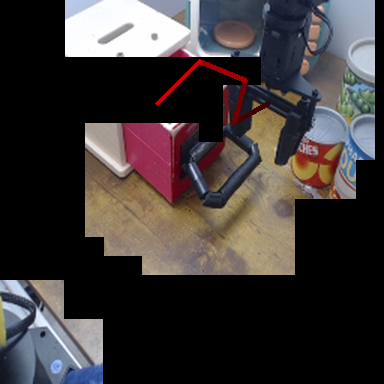

In [48]:
import numpy as np
from vila_utils.utils.encode import scale_path
from vila_utils.utils.decode import get_path_from_answer, add_mask_2d_to_img

img = np.array(images[0])
h, w, c = img.shape

# extract path from answer
out = get_path_from_answer(outputs, prompt_type)

# scale path to image size

scaled_mask = None
if "mask" in prompt_type:
    min_in, max_in = np.zeros(2), np.array([w,h])
    min_out, max_out = np.zeros(2), np.ones(2)
    mask = out[1] if len(out) == 2 else out
    scaled_mask = scale_path(mask, min_in=min_out, max_in=max_out, min_out=min_in, max_out=max_in)

scaled_path = None
if "path" in prompt_type:
    min_in, max_in = np.zeros(2), np.array([w,h])
    min_out, max_out = np.zeros(2), np.ones(2)
    path = out[0] if len(out) == 2 else out
    scaled_path = scale_path(path, min_in=min_out, max_in=max_out, min_out=min_in, max_out=max_in)

if "mask" in prompt_type and scaled_mask is not None:
    img = add_mask_2d_to_img(img, scaled_mask, mask_pixels=int(h*0.15))
    # img = add_mask_2d_to_img(img, scaled_path, mask_pixels=30 if resize_crop else 10)

if "path" in prompt_type and scaled_path is not None:
    # img = add_path_2d_to_img(img, scaled_path, color=(255,0,0))#, cmap="inferno")
    img = add_path_2d_to_img_alt_fast(img, scaled_path, line_size=3, circle_size=0, plot_lines=True)

print("quest:", quest)
Image.fromarray(img)

In [ ]:
break

In [129]:
from vila_utils.utils.inference import *

model_name = "vila_3b_oxe_no_droid"
model_path = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/checkpoints/finetuned/vila/"
base_name = None # "Efficient-Large-Model/VILA1.5-3b"
base_path = None
prompt_type = "path" # "mask", "path_mask"

args_dict = {
    
    "query": None,
    "image_file": None,

    # "video_file": None,
    "model_path": model_name if model_path is None else os.path.join(model_path, model_name),
    "conv_mode": "vicuna_v1",
    
    "model_base": base_name if base_path is None else os.path.join(base_path, base_name),
    "num_video_frames": 6,
    "sep": ",",
    "temperature": 0.2,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 1024,
}


args = argparse.Namespace(**args_dict)
model, tokenizer, image_processor, context_len = load_model(args)

from vila_utils.utils.prompts import get_prompt

quest = "grasp the pan"
args.query = get_prompt(quest, prompt_type)
args.image_file = "/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/example_imgs/droid_stove.png"

resize_crop = True


images, prompt, outputs = inference(model, tokenizer, image_processor, args, resize_crop)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [6]:
# images, prompt, outputs = inference(model, tokenizer, image_processor, args, resize_crop)


query:  <image>
In the image, please execute the command described in <quest>grasp the pan</quest>.
Provide a sequence of points denoting the trajectory of a robot gripper to achieve the goal.
Format your answer as a list of tuples enclosed by <ans> and </ans> tags. For example:
<ans>[(0.25, 0.32), (0.32, 0.17), (0.13, 0.24), (0.74, 0.21), ...]</ans>
The tuple denotes point x and y location of the end effector of the gripper in the image.
The coordinates should be integers ranging between 0.0 and 1.0, indicating the relative locations of the points in the image.

prompt:  A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <image>
In the image, please execute the command described in <quest>grasp the pan</quest>.
Provide a sequence of points denoting the trajectory of a robot gripper to achieve the goal.
Format your answer as a list of tuples enclosed by <ans> and </ans> tags. F

outputs:  <ans>[(0.66, 0.25), (0.61, 0.32), (0.64, 0.27)]</ans>


quest: grasp the pan


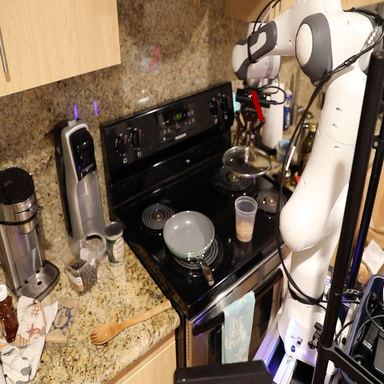

In [5]:
import numpy as np
from vila_utils.utils.encode import scale_path
from vila_utils.utils.decode import get_path_from_answer, add_mask_2d_to_img

img = np.array(images[0])
h, w, c = img.shape

# extract path from answer
out = get_path_from_answer(outputs, prompt_type)

scaled_mask = None
if "mask" in prompt_type:
    min_in, max_in = np.zeros(2), np.array([w,h])
    min_out, max_out = np.zeros(2), np.ones(2)
    mask = out[1] if len(out) == 2 else out
    scaled_mask = scale_path(mask, min_in=min_out, max_in=max_out, min_out=min_in, max_out=max_in)

scaled_path = None
if "path" in prompt_type:
    min_in, max_in = np.zeros(2), np.array([w,h])
    min_out, max_out = np.zeros(2), np.ones(2)
    path = out[0] if len(out) == 2 else out
    scaled_path = scale_path(path, min_in=min_out, max_in=max_out, min_out=min_in, max_out=max_in)

if "mask" in prompt_type and scaled_mask is not None:
    img = add_mask_2d_to_img(img, scaled_mask, mask_pixels=int(h*0.15))
    # img = add_mask_2d_to_img(img, scaled_path, mask_pixels=30 if resize_crop else 10)

if "path" in prompt_type and scaled_path is not None:
    # img = add_path_2d_to_img(img, scaled_path, color=(255,0,0))#, cmap="inferno")
    img = add_path_2d_to_img_alt_fast(img, scaled_path, line_size=3, circle_size=0, plot_lines=True)

print("quest:", quest)
Image.fromarray(img)